# Food chain art
This is a quick demo that creates cool animations based on a food chain simulator. It was based on the 2019/2020 Programming Elements class at IST from the Mathematics Department.

We'll start by importing some usefull stuff.

In [1]:
import random
import copy
from IPython.display import display, HTML
import PIL as pil
import PIL.Image
import PIL.ImageFilter
import matplotlib.pyplot as plt
import matplotlib.animation as anim
%matplotlib notebook

## ChainLevels class
A class to represent the colors for each of the food chain levels, used for rendering.
* ChainLevels(n_levels) - initialise *n_levels* levels with random colors.
* ChainLevels.randomColor() - helper to generate a random color.
* ChainLevels.getColor(level) - return the color for the level.
* ChainLevelr.nLevels() - return the number of levels.

In [2]:
class ChainLevels:
    
    def __init__(self, n_levels):
        self.colors = [self.randomColor() for i in range(n_levels)]
        
    def randomColor(self):
        return (random.random()*255, 0.8*255, 255)
    
    def getColor(self, level): return self.colors[level]
    def nLevels(self): return len(self.colors)

## Cell class
This class represents a cell of the world grid. It contains the percentages occupied by each of the food chain levels.
* Cell(n_levels, pos) - create a new cell.
* Cell.spaceAvailable() - the remaining space in the cell.
* Cell.levelOccupation(level) - the space occupied by that level in the cell.
* Cell.addToLevel(level, ammount) - occupy that ammount with species of level _level_.
* Cell.allocateToLevel(level, ammount) - replace the occupation with species of level _level_ with _ammount_.
* Cell.getPos() - return the position of the cell.

In [3]:
class Cell:
    
    def __init__(self, n_levels, pos):
        self.occupation = [0] * n_levels
        self.pos = pos
    
    def spaceAvailable(self):
        return 1.0 - sum(self.occupation)
    
    def levelOccupation(self, level):
        return self.occupation[level]
    
    def addToLevel(self, level, ammount):
        if ammount > self.spaceAvailable():
            self.occupation[level] += self.spaceAvailable()
        else:
            self.occupation[level] += ammount
        if self.occupation[level] < 0: self.occupation[level] = 0
    
    def allocateToLevel(self, level, ammount):
        if ammount - self.levelOccupation(level) > self.spaceAvailable():
            self.occupation[level] = self.spaceAvailable()
        else:
            self.occupation[level] = ammount
        if self.occupation[level] < 0: self.occupation[level] = 0
        
    def getPos(self): return self.pos

## Map class
This class represents a square map with cells. The map wraps around both axes.
* Map(n_levels, size) - creates a square map that supports a chain with *n_levels* with *size* squared cells.
* Map.toLinearCoord(col, row) - returns the index of the cell in the coordinates in the cell list.
* Map.getSize() - returns the size of the side of the map.
* Map.nCells() - returns the number of cells in the map.
* Map.getCell(col, row) - returns the cell in those coordinates.
* Map.getNeighborhood(col, row, radius) - returns the cells in a neighborhood of radius _radius_ of those coordinates.
* Map.getFreeCells() - returns the cells with available space.
* Map.getCellsWithLevel(level) - returns the cells that are occupied with species from that level.
* Map.isDryWeather() - returns if the weather is currently dry.
* Map.isHumidWeather() - returns if the weather is humid.
* Map.changeWeather() - shifts the weather in the map.
* Map.getCells() - return a list of all cells in the map.

In [4]:
class Map:
    
    def __init__(self, n_levels, size):
        self.cells = []
        for col in range(size):
            for row in range(size):
                self.cells += [Cell(n_levels, (col, row))]
        self.size = size
        self.weatherIsDry = False
        
    def toLinearCoord(self, col, row):
        return (row % self.size) * self.size + (col % self.size)
        
    def getSize(self): return self.size
    def nCells(self): return self.size ** 2
    
    def getCell(self, col, row):
        return self.cells[self.toLinearCoord(col, row)]
    
    def getNeighborhood(self, col, row, radius):
        cells = []
        for x in range(col - radius, col + radius + 1):
            for y in range(row - radius, row + radius + 1):
                if not self.getCell(x,y) in cells: cells += [self.getCell(x, y)]
        return cells
                
    def getFreeCells(self):
        return [cell for cell in self.cells if cell.spaceAvailable() > 0]
    
    def getCellsWithLevel(self, level):
        return [cell for cell in self.cells if cell.levelOccupation(level) > 0]
    
    def isDryWeather(self): return self.weatherIsDry
    def isHumidWeather(self): return not self.weatherIsDry
    def changeWeather(self): self.weatherIsDry = not self.weatherIsDry
    def getCells(self): return self.cells

## Map initializers
Functions to create maps initialized randomly or as an oasis.
* createRandomMap(size, level_ammounts) - creates a map with species randomly distributed.
* createOasisMap(size, n_levels) - creates a map with species of lower levels in the center.

In [5]:
def createRandomMap(size, level_ammounts):
    world = Map(len(level_ammounts), size)
    while sum(level_ammounts) > 0:
        level = random.choice([i for i in range(len(level_ammounts)) if level_ammounts[i] > 0])
        cell = random.choice(world.getFreeCells())
        if cell.spaceAvailable() > level_ammounts[level]:
            cell.addToLevel(level, level_ammounts[level])
            level_ammounts[level] = 0
        else:
            ammount = random.uniform(0, cell.spaceAvailable())
            cell.addToLevel(level, ammount)
            level_ammounts[level] -= ammount
    return world

def createOasisMap(size, n_levels):
    world = Map(n_levels, size)
    for cell in world.getNeighborhood(size // 2, size // 2, 1):
        cell.addToLevel(0, 0.8)
        cell.addToLevel(1, 0.2)
    for m in range(2, n_levels):
        for cell in world.getNeighborhood(size // 2, size // 2, m):
            if cell.spaceAvailable() > 0.6:
                cell.addToLevel(m, 0.1)
                cell.addToLevel(m-1, 0.4)
    return world

## Map renderer
This function takes a map and a ChainLevel structure and renders the map into an image. We also define a helper function to calculate the color of a cell.

In [6]:
def renderMap(world, chainLevels, zoom):
    img = pil.Image.new('HSV', (world.getSize(), world.getSize()))
    for col in range(world.getSize()):
        for row in range(world.getSize()):
            color = cellColor(world.getCell(col, row), chainLevels)
            img.putpixel((col, row), color)
    return img.convert('RGB').resize((world.getSize()*zoom, world.getSize()*zoom))

def cellColor(cell, chainLevels):
    color = (0,0,0)
    for level in range(chainLevels.nLevels()):
        color = (color[0] + chainLevels.getColor(level)[0] * cell.levelOccupation(level), \
                 color[1] + chainLevels.getColor(level)[1] * cell.levelOccupation(level), \
                 color[2] + chainLevels.getColor(level)[2] * cell.levelOccupation(level))
    return (int(color[0]), int(color[1]), int(color[2]))

## Let's test what we have so far!
Let's generate some maps and render them!

In [7]:
map1 = createRandomMap(250, [10]*40)
map2 = createOasisMap(250, 40)
cl1 = ChainLevels(20)
cl2 = ChainLevels(20)
img1 = renderMap(map1, cl1, 2)
img2 = renderMap(map2, cl2, 2)

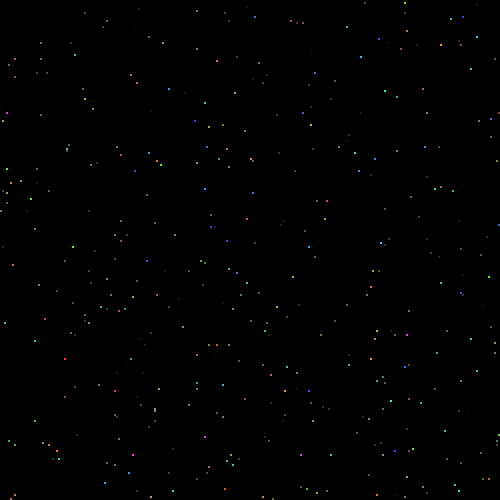

In [8]:
display(img1)

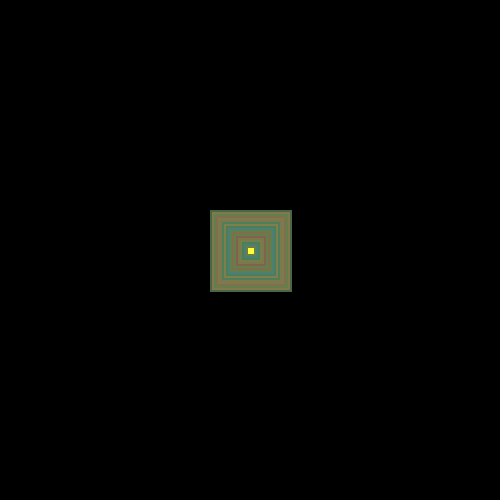

In [9]:
display(img2)

## Event classes
Classes to represent world events. Each has to implement the execute class, that executes the event on a map.
Event.getTime() - returns the time at which the event should run.
Event.execute(world, calendar, sim_props) - execute the event.

In [10]:
class Event:
    
    def __init__(self, time):
        self.time = time
        
    def getTime(self): return self.time
    
    def execute(self, world, calendar, sim_props):
        raise NotImplementedError()


class WeatherChangeEvent(Event):
    
    def __init__(self, time, average_dur):
        super().__init__(time)
        self.average_dur = average_dur
        
    def execute(self, world, calendar, sim_props):
        world.changeWeather()
        next_time = self.time + random.expovariate(1.0 / self.average_dur)
        calendar.add(WeatherChangeEvent(next_time, self.average_dur))


class LocalEvent(Event):
    
    def __init__(self, time, average_dur, cell, level):
        super().__init__(time)
        self.cell = cell
        self.level = level
        self.average_dur = average_dur
        
    def execute(self, world, calendar, sim_props):
        if self.level == 0:
            q0 = self.cell.levelOccupation(0)
            if world.isHumidWeather():
                qch = random.uniform(0.9 * sim_props.q_rain, min(1, 1.1 * sim_props.q_rain))
            else:
                qch = - sim_props.dry * q0
            n2 = world.getNeighborhood(self.cell.getPos()[0], self.cell.getPos()[1], 2)
            a2 = sum(map(lambda cell: cell.levelOccupation(0), n2))
            if a2 == 0: tcs = -1
            else:
                k2 = sum(map(lambda cell: 1.0 - cell.spaceAvailable() - cell.levelOccupation(0), n2))
                r = k2 / (2*a2)
                tcs = 0 if r < 1 else 1 - min(2,r)
            q = qch + q0 * (1 + tcs)
            self.cell.allocateToLevel(0, q)
        else:
            n1 = world.getNeighborhood(self.cell.getPos()[0], self.cell.getPos()[1], 1)
            am_level = sum(map(lambda cell: cell.levelOccupation(self.level), n1))
            if am_level > 0:
                m = self.level
                nm = world.getNeighborhood(self.cell.getPos()[0], self.cell.getPos()[1], m)
                am = sum(map(lambda cell: cell.levelOccupation(0), nm))
                tm = sum(map(lambda cell: 1 - cell.spaceAvailable() - cell.levelOccupation(0) \
                             - cell.levelOccupation(m), nm))
                r = am / tm if tm > 0 else 3
                if r < 1: fw = r - 1
                elif 1 <= r <= 2: fw = 2
                else: fw = max(1, r-2)
                n2 = world.getNeighborhood(self.cell.getPos()[0], self.cell.getPos()[1], 2)
                c2 = sum(map(lambda cell: cell.levelOccupation(m-1), n2))
                i2 = sum(map(lambda cell: cell.levelOccupation(m), n2))
                r = c2 / i2
                if r < 1: fa = r - 1
                elif 1 <= r <= 2: fa = 2
                else: fa = max(1, r-2)
                p2 = -sum(map(lambda cell: cell.levelOccupation(m+1), n2)) if m+1 < sim_props.n_levels else 0
                r = p2 / i2
                if r < 1: fp = r - 1
                elif 1 <= r <= 2: fp = 2
                else: fp = max(1, r-2)
                f = (fw + fa + fp - max(fw, fa, fp)) / 2
                if f < 0: t = random.uniform(0, 1+f)
                elif f == 0: t = random.uniform(0.9, 1.1)
                else: t = random.uniform(1, 1+f)
                q0 = self.cell.levelOccupation(m)
                q = q0 * t
                if q0 == 0 and f > 0:
                    qq0 = i2
                    t = random.uniform(0,1)
                    q = (qq0/4) * sim_props.r_migrate * t
                self.cell.allocateToLevel(m, q)
        next_time = self.time + random.expovariate(1.0 / self.average_dur)
        calendar.add(LocalEvent(next_time, self.average_dur, self.cell, self.level))
    

## Event Calendar class
A class to represent a calendar with events to be executed at specific times.
* Calendar() - creates an empty calendar.
* Calendar.add(event) - schedule an event.
* Calendar.get() - return the next event to execute.
* Calendar.pop() - pop the next event from the calendar.

In [11]:
class Calendar:
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        self.events = [e for e in self.events if e.getTime() <= event.getTime()] + [event] + \
            [e for e in self.events if e.getTime() > event.getTime()]
    
    def get(self):
        return self.events[0]
    
    def pop(self):
        self.events = self.events[1:]

## Simulation Properties class
A class to hold simulation properties given by the user.
* SimProps.n_levels - number of food chain levels.
* SimProps.map_size - size of an edge of the map.
* SimProps.duration - total duration of the simulation.
* SimProps.t_weather - average time between weather changes.
* SimProps.t_local - average time between local events.
* SimProps.r_migrate - the migration ratio.
* SimProps.p_rain - probability of raining.
* SimProps.q_rain - quantity of rain.
* SimProps.dry - the dry ratio.
* SimProps.n_steps - number of images to generate from the simulation.
* SimProps.map_mode - random map or oasis.
* SimProps.zoom - zoom of the output images.

In [12]:
class SimProps:
    
    def __init__(self, n_levels, map_size, duration, t_weather, \
                 t_local, r_migrate, p_rain, q_rain, dry, n_steps, map_mode, zoom):
        self.n_levels = n_levels
        self.map_size = map_size
        self.duration = duration
        self.t_weather = t_weather
        self.t_local = t_local
        self.r_migrate = r_migrate
        self.p_rain = p_rain
        self.q_rain = q_rain
        self.dry = dry
        self.n_steps = n_steps
        self.map_mode = map_mode
        self.zoom = zoom

## Do simulation
The function we've all been waiting for! It takes in a SimProps object, initializes a map and runs a simulation, saving the world states as it goes. Returns the list of worlds to be rendered.

In [13]:
def doSimulation(sim_props):
    # Create the map.
    if sim_props.map_mode == "random":
        world = createRandomMap(sim_props.map_size, \
                                [random.uniform(0, (sim_props.map_size**2) / sim_props.n_levels) \
                                 for i in range(sim_props.n_levels)])
    elif sim_props.map_mode == "oasis":
        world = createOasisMap(sim_props.map_size, sim_props.n_levels)
    else:
        raise ValueError('Unknown map mode.')
    chain_levels = ChainLevels(sim_props.n_levels)
    
    # Create the calendar and schedule initial events.
    calendar = Calendar()
    calendar.add(WeatherChangeEvent(random.expovariate(1.0 / sim_props.t_weather), sim_props.t_weather))
    for cell in world.getCells():
        for level in range(sim_props.n_levels):
            calendar.add(LocalEvent(random.expovariate(1.0 / sim_props.t_local), sim_props.t_local, \
                                   cell, level))
    
    # Run events until done:
    t = 0
    next_snap = 0
    snaps = []
    while t < sim_props.duration:
        event = calendar.get()
        while event.getTime() > next_snap:
            snaps += [renderMap(world, chain_levels, sim_props.zoom)]
            next_snap += sim_props.duration / sim_props.n_steps
        event.execute(world, calendar, sim_props)
        calendar.pop()
        t = event.getTime()
        if t >= sim_props.duration: break
    return snaps

## Let's run a simulation!
Let's define some SimProps and let a simulation run. We'll then look at the images.
This part takes a while... Go grab a cup of tea or something!

In [14]:
sim_props = SimProps( \
                    n_levels = 10, \
                    map_size = 10, \
                    duration = 10, \
                    t_weather = 1, \
                    t_local = 1, \
                    r_migrate = 0.8, \
                    p_rain = 0.01, \
                    q_rain = 0.01, \
                    dry = 0.8, \
                    n_steps = 30, \
                    map_mode = "oasis", \
                    zoom = 5 \
                    )

snaps = doSimulation(sim_props)

In [15]:
plt.ioff() # Do not draw plots, we'll render them as HTML5 video.
fig, ax = plt.subplots()
ax.axis('off')
an = anim.FuncAnimation(fig, lambda img: ax.imshow(img), frames=snaps)
HTML(an.to_html5_video())

## Image Effects
The following function applies effects to the images to get a more interesting result!

In [16]:
def postprocessing(snaps, interp):
    out = []
    last_img = None
    for snap in snaps:
        img = snap.filter(pil.ImageFilter.BoxBlur(3))
        img = snap.filter(pil.ImageFilter.GaussianBlur(3))
        img = img.filter(pil.ImageFilter.UnsharpMask())
        if last_img != None:
            for i in range(1, interp):
                i_img = pil.Image.blend(last_img, img, i / interp)
                out += [i_img]
        out += [img]
        last_img = img
    return out
        
psnaps = postprocessing(snaps, 5)

In [17]:
plt.ioff() # Do not draw plots, we'll render them as HTML5 video.
fig, ax = plt.subplots()
ax.axis('off')
an = anim.FuncAnimation(fig, lambda img: ax.imshow(img), frames=psnaps, interval=100)
HTML(an.to_html5_video())

## And now for the cool stuff!
The moment we've all been waiting for! A function to generate random mists based on the simulations!

In [18]:
def generate(size, zoom, n_frames):
    sim_props = SimProps( \
                    n_levels = random.randrange(5, 20), \
                    map_size = size, \
                    duration = random.randrange(10, 30), \
                    t_weather = random.uniform(0.1, 10), \
                    t_local = random.uniform(0.1, 1), \
                    r_migrate = random.uniform(0,1), \
                    p_rain = random.uniform(0,1), \
                    q_rain = random.uniform(0,1), \
                    dry = random.uniform(0,1), \
                    n_steps = n_frames, \
                    map_mode = random.choice(["oasis", "random"]), \
                    zoom = zoom \
                    )
    snaps = doSimulation(sim_props)
    psnaps = postprocessing(snaps, 5)
    return psnaps

final_snaps = generate(10, 10, 30)

In [19]:
plt.ioff() # Do not draw plots, we'll render them as HTML5 video.
fig, ax = plt.subplots()
ax.axis('off')
an = anim.FuncAnimation(fig, lambda img: ax.imshow(img), frames=final_snaps, interval=100)
HTML(an.to_html5_video())

## Conclusions
I guess this is mildly interesting, and maybe someone can get interesting results... A lot of stuff is randomized, so if you re-run the notebook you might get some interesting results.